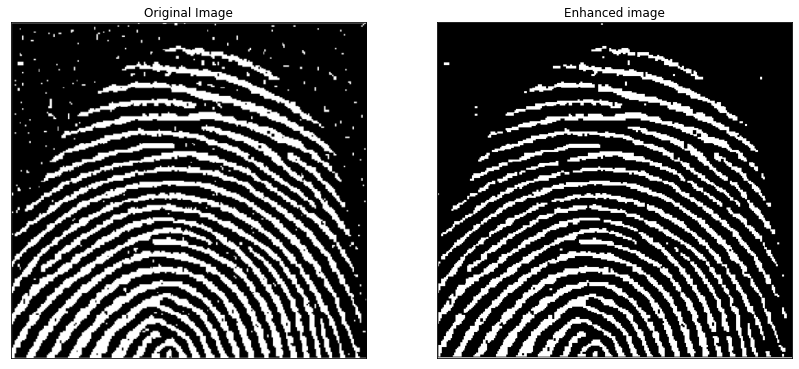

In [12]:
# fingerprint enhancement using morphology processes

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# dilation function
def hit(img,kernel):
    rows,cols = img.shape
    hittedimg = np.zeros((rows,cols),np.uint8)
    pad,_ = kernel.shape
    pad = pad//2
    
    # move the window over the image and find the hit pixels    
    for i in range(pad,rows-pad):
        for j in range(pad,cols-pad):
            for k in range(i-pad,i+pad+1):
                hit = False
                # compare inside window
                for l in range(j-pad,j+pad+1):
                    if img[k,l] == kernel[k - i + 1,l - j + 1] and kernel[k - i + 1,l - j + 1] == 255:
                        hit = True
                        break
                if hit:
                    hittedimg[i,j] = 255
                    break

    return hittedimg

# erosion function
def fit(img, kernel):
    rows,cols = img.shape
    fittedimg = np.ones((rows,cols),np.uint8)*255
    
    # move the window over the image and find the fit pixels 
    for i in range(1,rows-1):
        for j in range(1,cols-1):
            for k in range(i-1,i+2):
                notFit = False
                # compare inside window
                for l in range(j-1,j+2):
                    if img[k,l] != kernel[k - i + 1,l - j + 1] and kernel[k - i + 1,l - j + 1] == 255:
                        notFit = True
                        break
                if notFit:
                    fittedimg[i,j] = 0
                    break

    return fittedimg

def opening(img,kernel):
    fittedimg = fit(img,kernel)
    openedimg = hit(fittedimg,kernel)

    return openedimg

def closing(img,kernel):
    hittedimg = hit(img,kernel)
    closedimg = fit(hittedimg,kernel)

    return closedimg

img = cv.imread('fingerprint.png',0)

# creating a box structuring element
kernel = np.ones((3,3),np.uint8)*255

final_img = opening(img,kernel)

final_img = closing(final_img,kernel)

# lists used in displaying
images = [img,final_img]
titles = ['Original Image','Enhanced image']

# Displaying the image 
plt.figure(figsize=(14,14))
for i in range(2):
    plt.subplot(1,2,i+1)
    images[i] = cv.cvtColor(images[i],cv.COLOR_GRAY2RGB)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])

There are 14 disks in the image given.


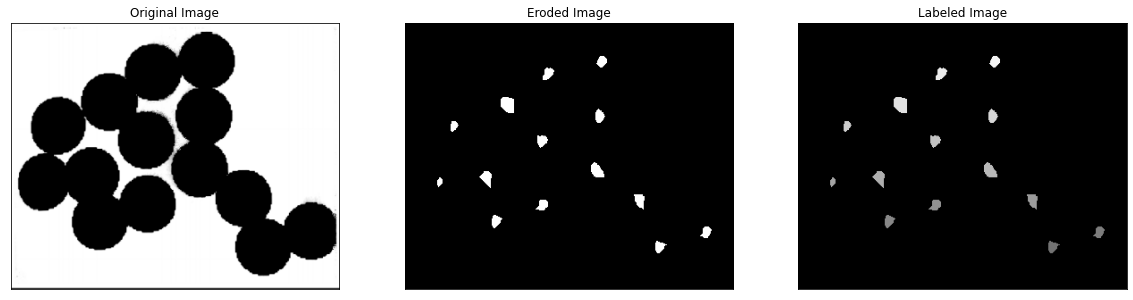

In [13]:
# finding number of particular shapes using morphology and CCL

import cv2 as cv
import matplotlib.pyplot as plt 

# fill N8 neighbours of a particular pixel with the given gray level
def fill_pix_neigh(img,i,j,lvl):
    rows,cols = img.shape
    for k in range(i-1,i+2):
        for l in range(j-1,j+2):
            if img[k,l] == 255:
                img[k,l] = lvl
                if (k != 0 and k != rows-1) and (l != 0 and l != cols-1):
                    fill_pix_neigh(img,k,l,lvl) 

# fill holes found in eroded image with distinct gray levels                     
def fill_lvls(img):
    rows,cols = img.shape
    lvl = 245
    
    for i in range(1,rows-1):
        for j in range(1,cols-1):
            if img[i,j] == 255:
                img[i,j] = lvl
                fill_pix_neigh(img,i,j,lvl)
                lvl -= 10

    return img

# return number of regions with distinct grey levels leaving black part
def countLabels(img):
    labels = [0]
    rows,cols = img.shape
    for i in range(rows):
        for j in range(cols):
            if img[i,j] != 0:
                if img[i,j] not in labels:
                    labels.append(img[i,j])

    return len(labels) - 1

img = cv.imread('disks.png',0)

# create a circular structuring element
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(6,6))

ret, img_edit = cv.threshold(img, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)

# taking the negative of the image
img_edit = cv.bitwise_not(img_edit)

# applying erosion
img_eroded = cv.erode(img_edit,kernel,iterations = 9)

# filling diiferent holes with distinct gray levels
img_labeled = fill_lvls(img_eroded.copy())

# getting number of distinct gray level labels
num = countLabels(img_labeled)

# lists used in displaying
images = [img,img_eroded,img_labeled]
titles = ['Original Image','Eroded Image','Labeled Image']

# Displaying the image 
plt.figure(figsize=(20,20))
for i in range(3):
    plt.subplot(1,3,i+1)
    images[i] = cv.cvtColor(images[i],cv.COLOR_GRAY2RGB)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])

print(f"There are {num} disks in the image given.")

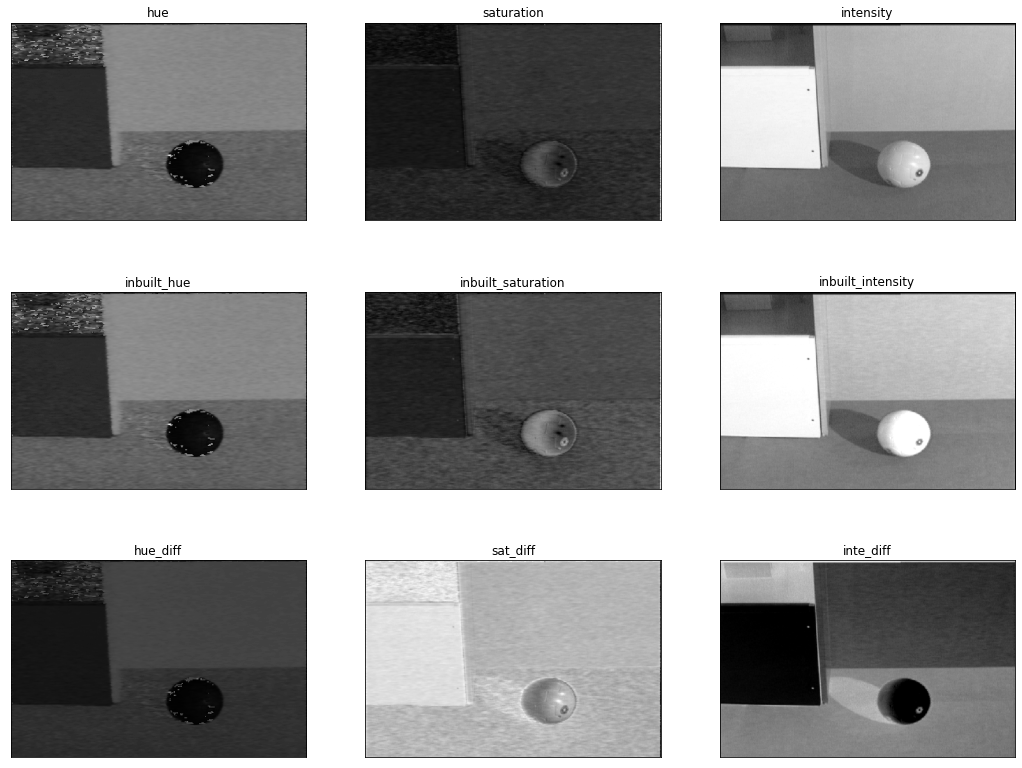

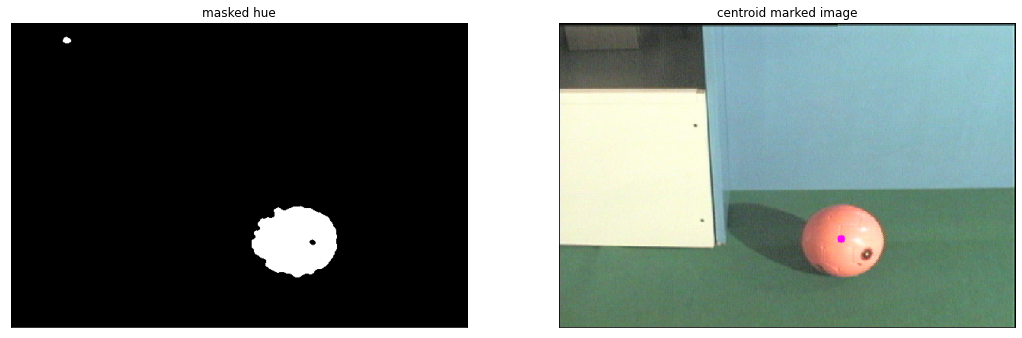

In [8]:
# implementing a RGB to HSV conversion and finding centroid of a particular shape

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import math

# function to convert RGB to HSV values
def getValues(B,G,R):
    rows,cols = B.shape

    # normalize the pixel values
    B = np.float32(B)/255
    G = np.float32(G)/255
    R = np.float32(R)/255

    # calculating intensity component
    intensity = np.divide(B + G + R, 3)

    # calculating saturation component
    minimum = np.minimum(np.minimum(R, G), B)
    saturation = 1 - (3 / (R + G + B) * minimum)

    # calculating hue component
    hue = R.copy()

    # iterating to get hue component of each pixel 
    for i in range(rows):
        for j in range(cols):
            Rval = R[i,j]
            Gval = G[i,j]
            Bval = B[i,j]

            # small value added in denominator to prevent divide by zero error
            w = 0.5*(Rval-Gval + Rval-Bval)/math.sqrt((Rval - Gval)*(Rval - Gval) + (Rval - Bval)*(Gval - Bval) + 0.000001)
            if w > 1:
                w = 1
            elif w < -1:
                w = -1

            hue[i][j] = math.acos(w)
            if Bval > Gval:
                hue[i][j] = 2*math.pi - hue[i][j]

            hue[i][j] = math.degrees(hue[i][j])

    return [hue,saturation,intensity]


img = cv.imread('ball.bmp')

# spilt image into its RGB components
B,G,R = cv.split(img)
rows,cols,_ = img.shape

hue,saturation,intensity = getValues(B,G,R)

# in-built function for conversion of RGB to HSV
HSI_img = cv.cvtColor(img,cv.COLOR_BGR2HSV)
cv_hue,cv_saturation,cv_intensity = cv.split(HSI_img)

# calculation difference between the components calculated
hue_diff = (hue - cv_hue)
sat_diff = (saturation - cv_saturation)
inte_diff = (intensity - cv_intensity)

# lists used for displaying
images = [hue,saturation,intensity,cv_hue,cv_saturation,cv_intensity,hue_diff,sat_diff,inte_diff]
titles = ["hue","saturation","intensity","inbuilt_hue","inbuilt_saturation","inbuilt_intensity","hue_diff","sat_diff","inte_diff"]

# Displaying the image
plt.figure(figsize=(18,14))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])

hue = hue/np.max(hue)
hue = hue*255

# converting from floating 32 bits to unsigned int 8 bits
hue = hue.astype('uint8')

# thresholding in hue space to get only the ball part of the image
ret,hue = cv.threshold(hue,30,255,cv.THRESH_BINARY_INV)

# opening and closing using a circular structuring element
element = cv.getStructuringElement(cv.MORPH_ELLIPSE,(7,7))
hue = cv.morphologyEx(hue, cv.MORPH_OPEN, element)
hue = cv.morphologyEx(hue, cv.MORPH_CLOSE, element)

# getting the coordinates of the centroid of the ball
M = cv.moments(hue)
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])

# marking the centroid on original image with pink color
cv.circle(img, (cX, cY), 5, (255,0,255), -1)

hue = cv.cvtColor(hue, cv.COLOR_GRAY2RGB)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# lists used for displaying
images = [hue,img]
titles = ["masked hue","centroid marked image"]

# Displaying the image
plt.figure(figsize=(18,14))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])

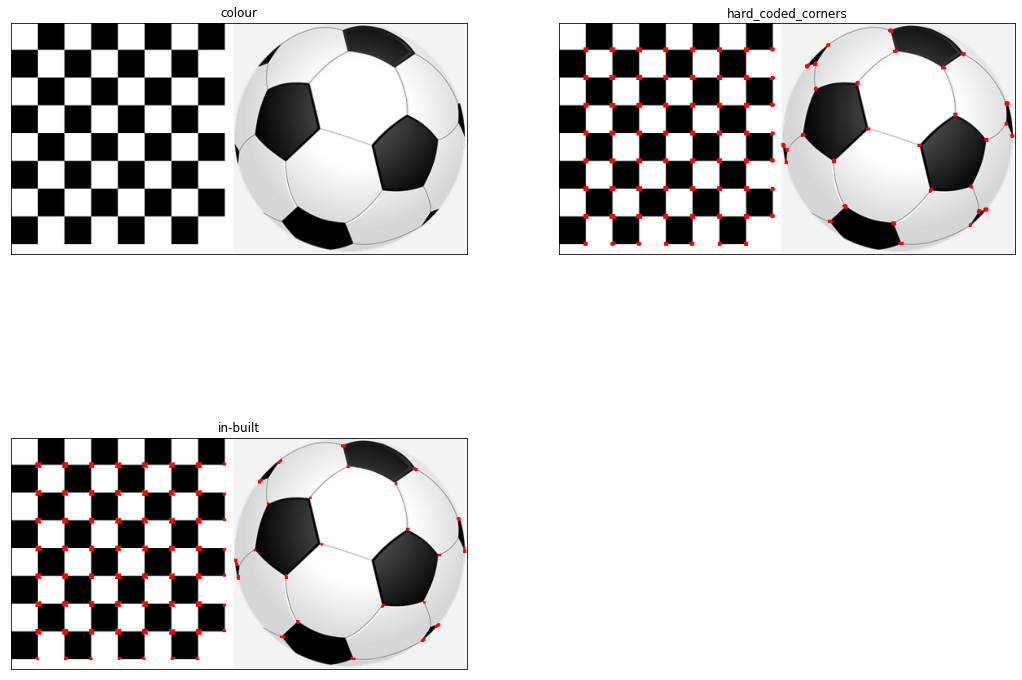

In [9]:
# comparison of in-built and hard-coded Harris Corner detection

import cv2 as cv
import matplotlib.pyplot as plt 
import numpy as np 

ddepth = cv.CV_32F

img = cv.imread('corner_test.png')
gray_img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

# convert pixel values to floating points
gray_img = np.float32(gray_img)
img_copy_for_corners = np.copy(img)

height,width = gray_img.shape

# getting first derivatives from Sobel filter
sobelx = cv.Sobel(gray_img,ddepth,1,0,ksize=3)
sobely = cv.Sobel(gray_img,ddepth,0,1,ksize=3)

# calculating gradient values for matrix 
Ixx = cv.GaussianBlur(sobelx**2, (3,3),1)
Ixy = cv.GaussianBlur(sobely*sobelx, (3,3),1)
Iyy = cv.GaussianBlur(sobely**2, (3,3),1)

# measure to change the amount of sharp corners we want
k = 0.05

# determinant of the matrix
detA = Ixx * Iyy - Ixy ** 2

# trace of the matrix
traceA = Ixx + Iyy
    
# scores obtained for every pixel 
harris_response = detA - k * traceA ** 2

# Results are marked through the dilated corners
harris_response = cv.dilate(harris_response, None)

# finding the max score obtained 
rmax = harris_response.max()

# applying the marking of corners
for rowindex, response in enumerate(harris_response):
    for colindex, r in enumerate(response):
        # thresholding to get the highest score corners only
        if r > 0.01 * rmax:
            img_copy_for_corners[rowindex, colindex] = [0,0,255]

imagec= img.copy()

# modify the data type setting to 32-bit floating point
operatedImage = np.float32(gray_img)
  
# apply the cv2.cornerHarris method to detect the corners with appropriate
# values as input parameters
dest = cv.cornerHarris(operatedImage, 2, 5, 0.07)
  
# Results are marked through the dilated corners
dest = cv.dilate(dest, None)

# Reverting back to the original image, with optimal threshold value
imagec[dest > 0.01 * dest.max()]=[0, 0, 255]

# lists used for displaying
images = [img,img_copy_for_corners,imagec]
titles = ["colour","hard_coded_corners","in-built"]

# Displaying the image 
plt.figure(figsize=(18,14))
for i in range(3):
    images[i] = cv.cvtColor(images[i],cv.COLOR_BGR2RGB)
    plt.subplot(2,2,i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])


([], [])

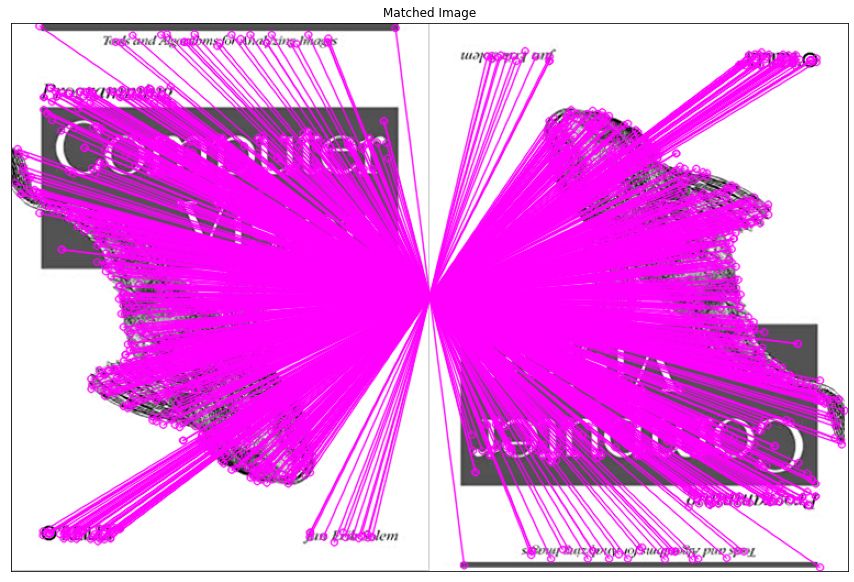

In [21]:
# doing feature matching using SIFT(for getting the features) and RANSAC(for matching those features)

import numpy as np
import cv2
from matplotlib import pyplot as plt

MIN_MATCH_COUNT = 10

# refernce image
img1 = cv2.imread('FM_img1.jpg',0) 

# image to match
img2 = cv2.imread('FM_img2.jpg',0)          

# creating a SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors using SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

# check whether enough feature points were detected to match
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    # implementation of RANSAC for feature matching   
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print("Not enough matches were found ->",len(good)," But needed ->",MIN_MATCH_COUNT)
    matchesMask = None

# draw matches in pink color (only inliners)
draw_params = dict(matchColor = (255,0,255), singlePointColor = None,matchesMask = matchesMask, flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

# displaying the image
plt.figure(figsize=(15, 15))
img3 = cv.cvtColor(img3,cv.COLOR_BGR2RGB)
plt.imshow(img3)
plt.title("Matched Image")
plt.xticks([])
plt.yticks([])